
# Álvaro Huertas García

## Notebook goals: 
In this notebook a new approach is employed based on the addition of labels to the entities recognised by ScispaCy. In addition, the use of an additional layer of SpatialDropout is explored and a cross validation study of the best optimizer is made. Only one layer LSTM RNN is used for comparison with the other approaches. The RNN has to calculate its own embeddings. This notebook is based on: https://towardsdatascience.com/nlp-text-preprocessing-a-practical-guide-and-template-d80874676e79

## Notebook' structure:
The structure of this notebook is:



*   Load the data

*   Split the data: train, test, validation

*   Categorical label to one hot vector
*   Text Preprocessing

  * Gene or Gene Products Labels
  * Diseases Labels

*   Text to index

*   Padding

* Evaluation 
  * Single LSTM
  * Single LSTM with Spatial Dropout

* Grid Search Neuronal Network Optimizer






In [1]:
install = True
if install: 

  !pip install Unidecode


  !pip install word2number

  !pip install scispacy
  # For nothing
  !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_sm-0.2.4.tar.gz
  # For nothing
  !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_bionlp13cg_md-0.2.4.tar.gz
  # Detect chemicals and diseases
  !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_bc5cdr_md-0.2.4.tar.gz
  # Detect RNA, DNA, cell, cell lines, proteins
  !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_jnlpba_md-0.2.4.tar.gz

  # Language, stop words and num substitution
  !python -m spacy download en_core_web_sm

     |████████████████████████████████| 245kB 4.7MB/s 
  Created wheel for word2number: filename=word2number-1.1-cp36-none-any.whl size=5587 sha256=8d25b8e3a76fd007c105ba0f625a6f44f1028448f374724ae055f4271755e96e
  Stored in directory: /root/.cache/pip/wheels/46/2f/53/5f5c1d275492f2fce1cdab9a9bb12d49286dead829a4078e0e
Successfully built word2number
     |████████████████████████████████| 3.0MB 11.0MB/s 
     |████████████████████████████████| 13.0MB 270kB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 6.2MB 13.0MB/s 
     |████████████████████████████████| 296kB 43.2MB/s 
  Created wheel for scispacy: filename=scispacy-0.2.4-cp36-none-any.whl size=35204 sha256=db8c82c4d1b467fa9fdd0400fe8b87fb6538997d62f95e55b07da84cbf34dbb5
  Stored in directory: /root/.cache/pip/wheels/36/5e/7c/ba8d6b02f5cfa40735e40ccffd29852ca19ebca59393afd5f0
Successfully built scispacy
  Found existing installation: rsa 4.0
    Uninstalling rsa-4.0:
      Successful

     |████████████████████████████████| 17.0MB 252kB/s 
  Created wheel for en-core-sci-sm: filename=en_core_sci_sm-0.2.4-cp36-none-any.whl size=17161110 sha256=730506d796a339376a6d4f6c328a8f93492c8a1fede31c3aa6fcc2aac98be75a
  Stored in directory: /root/.cache/pip/wheels/34/60/b9/fabd9c3eeba17ed66df745479f2fc502a6702755cb4a9632f2
Successfully built en-core-sci-sm
     |████████████████████████████████| 70.1MB 89kB/s 
  Created wheel for en-ner-bionlp13cg-md: filename=en_ner_bionlp13cg_md-0.2.4-cp36-none-any.whl size=70542687 sha256=fe8454354215437cc18e4c3c71e91ee2ff25e1562446e66661bc9dc0ba907ef2
  Stored in directory: /root/.cache/pip/wheels/ef/2a/a6/014a4ac046ce7e0afeba214dc8ca1ab1bd5cbf05c4b77b28ec
Successfully built en-ner-bionlp13cg-md
     |████████████████████████████████| 70.1MB 113kB/s 
  Created wheel for en-ner-bc5cdr-md: filename=en_ner_bc5cdr_md-0.2.4-cp36-none-any.whl size=70531467 sha256=2ec8158179e99a7a8e108dcf4ffeeb35adacfe54415743bad5f7a974c32bf14a
  Stored in directo

In [2]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from bs4 import BeautifulSoup
import spacy
import unidecode
from word2number import w2n
# from pycontractions import Contractions
import gensim.downloader as api# load spacy model, can be "en_core_web_sm" as well
# nlp = spacy.load('en_core_web_md')# Choose model accordingly for contractions function
# model = api.load("glove-twitter-25")
# model = api.load("glove-twitter-100")
# model = api.load("word2vec-google-news-300")
import collections


from keras.datasets import imdb
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, LSTM, Dropout, SpatialDropout1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.embeddings import Embedding
from keras import regularizers
from keras.constraints import UnitNorm
from keras.preprocessing import sequence
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer, one_hot # Codificar palabras a numeros
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool, LabelSet, ColumnDataSource, Range1d
from bokeh.plotting import figure, show, output_notebook

from gensim.models.word2vec import Word2Vec # word2vec model gensim class
from gensim.models.doc2vec import TaggedDocument

from IPython.display import SVG, clear_output
from keras.utils.vis_utils import model_to_dot


import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

lemmatizer = WordNetLemmatizer().lemmatize
import gensim # pip install gensim
from gensim.models.word2vec import Word2Vec # word2vec model gensim class
TaggedDocument = gensim.models.doc2vec.TaggedDocument

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Load the data

In [3]:
COLAB = True
if COLAB:
    %tensorflow_version 1.x

if COLAB:
    import urllib
    # https://drive.google.com/file/d/1zJuh8XJTf_5hPZ8jVEUtGW1BnBZ6Yy4z/view?usp=sharing
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1zJuh8XJTf_5hPZ8jVEUtGW1BnBZ6Yy4z",
                              "precision_medicine.zip")
    # https://drive.google.com/file/d/1PcVSBLgIpJVXAj4JD8_EQAGprte4zuyn/view?usp=sharing
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1PcVSBLgIpJVXAj4JD8_EQAGprte4zuyn",
                              "long_stop_words.txt")

TensorFlow is already loaded. Please restart the runtime to change versions.


In [4]:
f = open("long_stop_words.txt", "+r")
long_stopwords = f.read().split("\n")
len(long_stopwords)

853

In [5]:
!unzip precision_medicine.zip 

Archive:  precision_medicine.zip
   creating: precision_medicine/
  inflating: precision_medicine/Alzheimer_abstracts.tsv  
   creating: __MACOSX/
   creating: __MACOSX/precision_medicine/
  inflating: __MACOSX/precision_medicine/._Alzheimer_abstracts.tsv  
  inflating: precision_medicine/Bladder_Cancer_abstracts.tsv  
  inflating: __MACOSX/precision_medicine/._Bladder_Cancer_abstracts.tsv  
  inflating: precision_medicine/Breast_Cancer_abstracts.tsv  
  inflating: __MACOSX/precision_medicine/._Breast_Cancer_abstracts.tsv  
  inflating: precision_medicine/Cervical_Cancer_abstracts.tsv  
  inflating: __MACOSX/precision_medicine/._Cervical_Cancer_abstracts.tsv  
  inflating: precision_medicine/negative_abstracts.tsv  
  inflating: __MACOSX/precision_medicine/._negative_abstracts.tsv  
  inflating: __MACOSX/._precision_medicine  


In [0]:
files = [('Alzheimer_abstracts.tsv', 'Alzheimer'),
         ('Bladder_Cancer_abstracts.tsv', 'Bladder Cancer'),
         ('Breast_Cancer_abstracts.tsv', 'Breast Cancer'),
         ('Cervical_Cancer_abstracts.tsv', 'Cervical Cancer'),
         ('negative_abstracts.tsv', 'Negative'),]

input_folder = './precision_medicine/'

In [0]:
def load_file(file_name):
    with open(file_name) as f:
        examples = []
        content = f.readlines()
        for l in content:
            aux = l.split('\t')
            examples.append((aux[0], (' '.join(aux[1:])).replace('\n', ' ')))
        return examples

In [8]:
# Variables donde almacenamos cada texto y su etiqueta
narratives = []
labels = []

# Para cada uno de los 5 archivos extraemos sus textos y le asignamos la etiqueta
for f,label in files:
    aux = load_file(input_folder + f)
    narratives.extend([x[1] for x in aux])
    labels.extend(len(aux)*[label])

labels = np.array(labels)

len(narratives), len(labels)

(5000, 5000)

# Split the data: train. test, validation

In [18]:
from sklearn.model_selection import train_test_split

# Divido los datos en test&validación y entrenamiento
narratives_tr, narratives_te_val, y_tr, y_te_val = train_test_split(narratives, labels,
                                                            test_size=0.3, random_state=0, stratify = labels)

print("Number of test examples: {}".format(len(narratives_tr)))

# Dividimos test&validacion en test y validacion
narratives_te, narratives_val, y_te, y_val =  train_test_split(narratives_te_val, y_te_val,
                                                            test_size=0.5, random_state=0, stratify = y_te_val)

print("Number of training examples: {} \nNumber of validation examples: {}".format(len(narratives_te), len(narratives_val)))



# Labels set to one hot representation
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","), binary= False)
y_tr_num = vectorizer.fit_transform(y_tr)
y_val_num = vectorizer.fit_transform(y_val)
y_te_num = vectorizer.fit_transform(y_te)

Number of test examples: 3500
Number of training examples: 750 
Number of validation examples: 750


In [19]:
collections.Counter(y_tr)

Counter({'Alzheimer': 700,
         'Bladder Cancer': 700,
         'Breast Cancer': 700,
         'Cervical Cancer': 700,
         'Negative': 700})

# Categorical label to one hot vector

<font color="orange"><h1 align="left">Categorical label to one hot vector</h1></font>

In [0]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","), binary= False)
y_tr_num = vectorizer.fit_transform(y_tr)
y_val_num = vectorizer.fit_transform(y_val)
y_te_num = vectorizer.fit_transform(y_te)

<font color="red"><h1 align="left"> Bigrams</h1></font>


In [0]:
def count_bigram(vocab, docs, topn = 10):
  '''Extract topn frequent bigrams '''
  lista = []
  bigrams = list(vocab.keys())
  for i in bigrams:
    apariciones = 0
    for texto in docs:
      apariciones += len(re.findall(i, texto.lower()))
    lista.append( (i, apariciones) )
  ordenada = sorted(lista, key = lambda k: k[1], reverse=True)
  return ordenada[:topn]

In [0]:
def my_cool_preprocessor(text):
  '''Pre-process text for extract bigrams'''

  text = re.sub(r"[A-Z]+:", "", text)
  tokenized_text = nltk.word_tokenize(text)
  

  tokenized_text = [i.lower() for i in tokenized_text if i != " NUM "]

  from string import punctuation
  stop_words = set(long_stopwords) # using a bigger one +800 words
  punctuation_marks = set(punctuation)

  tokenized_text = [i for i in tokenized_text if i not in punctuation_marks]
  tokenized_text = [i for i in tokenized_text if i not in stop_words]

  # Lemmanizamos, dado que queremos los bigram en singular
  tokenized_text = [lemmatizer(word) for word in tokenized_text]
  full_text = ' '.join(tokenized_text)
  return full_text

In [0]:
# ignore terms that appeared in less than 2 documents 
# ignore terms that appear in 95% of the documents
cv = CountVectorizer(narratives_tr, ngram_range=(2,2), min_df=0.01, max_df=0.95, preprocessor=my_cool_preprocessor, max_features=10000)
count_vector=cv.fit_transform(narratives_tr)

In [0]:
# Extract topn bigrams
bigrams = count_bigram(cv.vocabulary_, narratives_tr, topn = 100)

In [25]:
import plotly.graph_objects as go
y_values = [i[1] for i in bigrams[:20]]
x_values = [i[0] for i in bigrams[:20]]
fig = go.Figure(
    data=[go.Bar(x = x_values, y= y_values)],
    layout_title_text="Top 20 bigrams after pre-processing",
)
fig.show()

# Text Pre-processing

<font color="orange"><h1 align="left">Text Pre processing</h1></font>

In [0]:
from string import punctuation

# abbreviation_pipe = AbbreviationDetector(nlp_core)
# nlp_core.add_pipe(abbreviation_pipe)

def clean_text(text, bigrams):

  # Text to unicode
  text = unidecode.unidecode(text)

  # Sections
  text = re.sub("[A-Z]{0,}\s[A-Z]+:", "", text) 

  # Lowercase and remove extra spaces
  text = text.strip().lower()
  
  # E mail
  text = re.sub(r"e\s?-\s?mail", "email", text)

  # P value
  text = re.sub('p\s?[<=]\s?0?[.,]0[0-5]+', 'hppv', text) # Significant
  text = re.sub('p\s?[>=]\s?[\d]+[.,]?\d*', 'lppv', text) # Non-significant


    # Bigrams
  for tupla in bigrams:
    bigram = tupla[0]
    text = re.sub(rf"{bigram}s?", rf"bigram {bigram}", text)


  # Punctuation
  punctuation_updated = set(punctuation) - set([',', '.', '(', ')', '-'])

  for i in punctuation_updated:
    element = "\\"+i # scape the character
    sub_element = " "+i+" " # Example "=" --> " = "
    text = re.sub(element, sub_element, text)


  # Numbers '[^A-Za-z][\-~]?[0-9][0-9]*\s?[.,]?\s?[0-9]+', " NUM ", '[^A-Za-z][\-~]?[1-9][0-9]*\s?\.?\s?[0-9]+', " NUM "
  text = re.sub( '[^A-Za-z][\-~]?[0-9][0-9]*\s?[.,]?\s?[0-9]+[^A-Za-z]', " num ", text)
  
  text = re.sub( "\s[0-9]+\s", " num ", text)


  # Double to single space
  text = re.sub(r"\s{2,}", " ", text)
  

  

  return text

In [0]:
# TRAIN

# New variable where we collect the clean training data
clean_tr = []

# In each iteration a text is cleaned
i = 0
for text in narratives_tr:
  clean = clean_text( text, bigrams) 
  clean_tr.append( clean )

# TEST
# New variable where we collect the clean test data
clean_te = []

# In each iteration a text is cleaned
for text in narratives_te:
  clean = clean_text( text, bigrams) 
  clean_te.append( clean )

# VALIDATION
# New variable where we collect the clean test data
clean_val = []

# In each iteration a text is cleaned
for text in narratives_val:
  clean = clean_text( text, bigrams ) 
  clean_val.append( clean )

In [30]:
print(narratives_tr[0])
print(clean_tr[0])

Do invitations for cervical screening provide sufficient information to enable informed choice? A cross-sectional study of invitations for publicly funded cervical screening. OBJECTIVE: To investigate whether invitations for publicly funded cervical screening provide sufficient information to enable an informed choice about participation. DESIGN: Cross-sectional study using a checklist of 23 information items on benefits and harms from cervical screening and the risks related to cervical cancer. MATERIAL: Invitations to publicly funded cervical screening in 10 Scandinavian and English-speaking countries. SETTING: Ten Scandinavian and English speaking countries. PARTICIPANTS: Sixteen screening units representing 10 Scandinavian and English speaking countries. MAIN OUTCOME MEASURES: Number of information items presented in invitations for cervical screening. RESULTS: We contacted 21 coordinating units from 11 countries and 20 (95%) responded. Of these, four units did not issue invitation

In [31]:
print(narratives_tr[2320])
print(clean_tr[2320])

Low-dose irradiation promotes proliferation of the human breast cancer MDA-MB-231 cells through accumulation of mutant P53. Low-dose irradiation (LDIR) has been proven to have differential biological effects on normal mammalian somatic cells and cancer cells. Our previous study showed that p53 gene status is a critical factor regulating the effect of LDIR on cancer cells. We investigated the effect of LDIR on the breast cancer cell line MDA-MB-231 that harbors a mutant p53 gene, and the normal breast fibroblast cell line Hs 578Bst. In the present study, we showed that 150 mGy LDIR pormoted growth of MDA-MB-231 cells but not Hs 578Bst cells. Through cell cycle analyses, we found that LDIR accelerated cell cycle into S phase in MDA-MB-231 cells, but did not affect the cell cycle of Hs 578Bst cells. Using western blotting, we demonstrated that the expression of CDK4, CDK6 and cyclin D1 was upregulated in MDA-MB-231 cells after LDIR. Although LDIR increased ataxia-telangiectasia mutated (A

## Gene or Gene Products


Ahora vamos a intentar identificar genes o productos génicos gracias a scispacy. Antes de nada, juntaremos todo el texto, lo tokenizaremos y lemmanizaremos para que las entidades sean extraidas de un corpus limpio. Luego, las entidades biológicas encontradas se les añadirá una etiqueta para ayudar a la red neuronal recurrente a obtener mejores resultados. 

In [32]:
# The full clean text will be used to count the frequency of the entities extracted
clean_corpus = ' '.join(clean_tr)
len(clean_corpus)

5730784

In [0]:
# Texto tokenizado y pre-procesado para identificar más facilmente entidades biologicas
tokenized_tr = []
for text in clean_tr:
  tokenized_tr.append(my_cool_preprocessor(text))

  len(tokenized_tr )

Podemos ver como ha ido cambiando el texto desde el aspecto original, al limpiado y, por último, al tokenizado. El tokenizado pierde muchos conectores que resultan interesantes para la red neuronal, por eso el texto tolenizado sólo se emplea para extraer las entidades biológicas. A esas entidades biológicas identificadas se les añadirá una etiqueta en el texto limpio pero con conectores. 

In [34]:
print(narratives_tr[0])
print(clean_tr[0])
print(tokenized_tr[0])

Do invitations for cervical screening provide sufficient information to enable informed choice? A cross-sectional study of invitations for publicly funded cervical screening. OBJECTIVE: To investigate whether invitations for publicly funded cervical screening provide sufficient information to enable an informed choice about participation. DESIGN: Cross-sectional study using a checklist of 23 information items on benefits and harms from cervical screening and the risks related to cervical cancer. MATERIAL: Invitations to publicly funded cervical screening in 10 Scandinavian and English-speaking countries. SETTING: Ten Scandinavian and English speaking countries. PARTICIPANTS: Sixteen screening units representing 10 Scandinavian and English speaking countries. MAIN OUTCOME MEASURES: Number of information items presented in invitations for cervical screening. RESULTS: We contacted 21 coordinating units from 11 countries and 20 (95%) responded. Of these, four units did not issue invitation

Ahora vamos a extraer entidades biológicas del conjunto de los textos limpiados, y añadir una etiqueta en el texto para ayudar a la red a detectar la importancia biológica que tienen. 


Para ello usaremos spacy y scispacy. Emplearemos `en_ner_bionlp13cg_md` 	A spaCy NER model trained on the BIONLP13CG corpu


In [0]:
import scispacy
import spacy
import en_core_web_sm # NUM
import en_core_sci_sm   #The model we are going to use
import en_ner_bionlp13cg_md # GENE_OR_GENE_PRODUCT
import en_ner_bc5cdr_md # DISEASE
import en_ner_jnlpba_md
from scispacy.abbreviation import AbbreviationDetector

Dado que el límite  de longitud es 100000 palabras y nuestro texto tiene 5590373, vamos a crear 5 conjuntos del entrenenamiento para extraer entidades biológicas. 




In [0]:
def chunkIt(seq, num):
    # split list into num parts
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

In [0]:
splits = chunkIt(tokenized_tr, 100) # split tokenized text for searching bio-entities
nlp = en_ner_bionlp13cg_md.load()

In [38]:
len(splits[2])

35

In [0]:
nlp = en_ner_bionlp13cg_md.load()
bio_ent = []
for split in splits:
  corpus = " ".join(split)
  corpus = nlp(corpus)
  for token in corpus.ents:
    if token.label_ == "GENE_OR_GENE_PRODUCT" and token.text not in bio_ent and "num" not in token.text and "(" not in token.text and ")" not in token.text and len(token.text) != 1 and "." not in token.text and token.text != "hppv" and token.text != "lppv" and "bigram" not in token.text:
      bio_ent.append(token.text)

We do not want that a gene or gene product entity will be only a greek letter. 

In [0]:
greek_alphabet = {
    u'\u03B1': 'alpha',
    u'\u03B2': 'beta',
    u'\u03B3': 'gamma',
    u'\u03B4': 'delta',
    u'\u03B5': 'epsilon',
    u'\u03B6': 'zeta',
    u'\u03B7': 'eta',
    u'\u03B8': 'theta',
    u'\u03B9': 'iota',
    u'\u03BA': 'kappa',
    u'\u03BB': 'lamda',
    u'\u03BC': 'mu',
    u'\u03BD': 'nu',
    u'\u03BE': 'xi',
    u'\u03BF': 'omicron',
    u'\u03C0': 'pi',
    u'\u03C1': 'rho',
    u'\u03C3': 'sigma',
    u'\u03C4': 'tau',
    u'\u03C5': 'upsilon',
    u'\u03C6': 'phi',
    u'\u03C7': 'chi',
    u'\u03C8': 'psi',
    u'\u03C9': 'omega',
}

In [41]:
"alpha tnf" in greek_alphabet.values()

False

In [42]:
corpus = " ".join(clean_tr)
freq_bio_ent = []
i = 0
for ent in bio_ent:
  if ent not in greek_alphabet.values() :
    i += 1
    print(ent, i)
    freq = len(re.findall(f" {ent} ", corpus))
    freq_bio_ent.append( (ent, freq) )

bc 1
scc 2
c1qc c1qb s100a8 s100a9 3
faq 4
sdb 5
mos-ss 6
wmh 7
pbx1 8
estrogen receptor er 9
pre-b-cell leukemia homeobox-1 10
hmgcs2 11
dhrs2 hmgcs2 12
alox15b 13
glyatl1 14
basal- 15
erbb2 16
asc-h 17
asc 18
monoamine monoamine oxidase type 19
mao-b 20
ec50 1-2 21
hppv7 22
vimentin 23
cd30 24
cd3 cd20 25
ae3 26
hmb45 melan desmin 27
cd3 28
fdc 29
cd21 30
samp8 mouse 31
il-1beta 32
low-dose tf-lbm 33
il-6 34
tf-lbm 35
tnf-alpha 36
low-dose median-dose tf-lbm 37
il-1beta il-6 tnf-alpha 38
il-6 il-1beta 39
hpv 40
hpv 9 41
p53 42
sco2 43
nedaplatin- 44
ha-ras 45
alpha kinase inhibition 46
mtor 47
tsc1 48
factor factor factor 49
hppv8 50
ckd 51
postt1 52
postt2 53
tau fibril 54
lvc 55
beta-amyloid 56
app695swe 57
synapsin-1 synaptophysin 58
mir-9 59
camkk2 60
essex-lopresti-type 61
pde4 62
pde4is 63
lci 64
escherichia coli shigella dysenteriae type 1 citrobacter freundii 65
ld50 66
shrm 67
suvmax suvmean 68
brca2 69
brca1 70
dicer1 71
lymphovascular invasion lvi 72
lvi endothelial 73
cd3

In [43]:
len(bio_ent)

4224

In [44]:
top_bio_ent = sorted(freq_bio_ent, key = lambda k: k[1], reverse = True)
top_bio_ent[:500]

[('hpv', 659),
 ('amyloid', 258),
 ('mcf-7', 172),
 ('bc', 166),
 ('p53', 157),
 ('her2', 138),
 ('fdg', 112),
 ('t24', 94),
 ('insulin', 93),
 ('lipid', 86),
 ('p16', 81),
 ('adc', 81),
 ('kaplan-meier', 81),
 ('cin', 77),
 ('bca', 76),
 ('amyloid-beta', 75),
 ('antigen', 71),
 ('mtt', 68),
 ('akt', 67),
 ('histone', 66),
 ('beta-amyloid', 65),
 ('egfr', 64),
 ('bcl-2', 64),
 ('csf', 64),
 ('estrogen receptor', 58),
 ('bcg', 57),
 ('cin2', 57),
 ('wnt', 54),
 ('emt', 52),
 ('vegf', 52),
 ('sirna', 49),
 ('microglia', 49),
 ('brca1', 48),
 ('il-6', 44),
 ('caspase-3', 42),
 ('cd4', 42),
 ('nf-kappab', 41),
 ('green', 40),
 ('hpv16', 40),
 ('scc', 39),
 ('jnk', 38),
 ('mcf7', 38),
 ('acetylcholinesterase', 37),
 ('pi3k', 36),
 ('leep', 36),
 ('hpv dna', 36),
 ('vimentin', 35),
 ('qol', 35),
 ('amyloid beta', 35),
 ('gata3', 35),
 ('cholinergic', 35),
 ('mtor', 34),
 ('collagen', 34),
 ('hcc', 34),
 ('p21', 34),
 ('hotair', 34),
 ('apolipoprotein', 33),
 ('ra', 32),
 ('bace1', 31),
 ('pa

In [45]:
import plotly.graph_objects as go
y_values = [i[1] for i in top_bio_ent[:20]]
x_values = [i[0] for i in top_bio_ent[:20]]
fig = go.Figure(
    data=[go.Bar(x = x_values, y= y_values)],
    layout_title_text="Top 20 bio-entities detected by scispacy", 
    
)
fig.show()

Ahora se lo añadimos al texto. Los terminos serán acompañados con la etiqueta `(bio_ent)`


In [46]:
len(clean_tr)

3500

Ahora procedemos a añadir en el texto limpio la etiqeta `bioent` a las entidades biológicas identificadas en el texto limpio tokenizado.  

In [0]:
def add_bio_ent(text):
  for tupla in top_bio_ent[:500]:
    ent = tupla[0]
    text = re.sub(rf" {ent} ",rf" {ent} bioent ", text)
  return text

In [0]:
bio_tr = []
for text in clean_tr: # texto limpio
  bio_tr.append(add_bio_ent(text))

# Test
bio_te = []
for text in clean_te:
  bio_te.append(add_bio_ent(text))


# Validation
bio_val = []
for text in clean_val:
  bio_val.append(add_bio_ent(text))

In [49]:
len(bio_tr)

3500

Un ejemplo de como el texto limpio ahora incorpora el término `bioent` y `bigram`. Por ejemplo, podemos ver:

* "androgen receptor" --> bioent

* "breast cancer" --> bigram

In [50]:
print(narratives_tr[2320])
bio_tr[2320]

Low-dose irradiation promotes proliferation of the human breast cancer MDA-MB-231 cells through accumulation of mutant P53. Low-dose irradiation (LDIR) has been proven to have differential biological effects on normal mammalian somatic cells and cancer cells. Our previous study showed that p53 gene status is a critical factor regulating the effect of LDIR on cancer cells. We investigated the effect of LDIR on the breast cancer cell line MDA-MB-231 that harbors a mutant p53 gene, and the normal breast fibroblast cell line Hs 578Bst. In the present study, we showed that 150 mGy LDIR pormoted growth of MDA-MB-231 cells but not Hs 578Bst cells. Through cell cycle analyses, we found that LDIR accelerated cell cycle into S phase in MDA-MB-231 cells, but did not affect the cell cycle of Hs 578Bst cells. Using western blotting, we demonstrated that the expression of CDK4, CDK6 and cyclin D1 was upregulated in MDA-MB-231 cells after LDIR. Although LDIR increased ataxia-telangiectasia mutated (A

'low-dose irradiation promotes proliferation of the human bigram breast cancer mda-mb num cells through accumulation of mutant p53. low-dose irradiation (ldir) has been proven to have differential biological effects on normal mammalian somatic cells and bigram cancer cell. our previous study showed that p53 bioent gene status is a critical factor regulating the effect of ldir on bigram cancer cell. we investigated the effect of ldir on the bigram breast bigram cancer bigram cell line mda-mb num that harbors a mutant p53 bioent gene, and the normal breast fibroblast bioent bigram cell line hs num bst. in the present study, we showed that num mgy ldir pormoted growth of mda-mb num cells but not hs num bst cells. through bigram cell cycle analyses, we found that ldir accelerated bigram cell cycle into s phase in mda-mb num cells, but did not affect the bigram cell cycle of hs num bst cells. using bigram western blotting, we demonstrated that the expression of cdk4, cdk6 bioent and cyclin 

## Diseases
Realizaremos el mismo proceso para enfermedades


In [0]:
nlp = en_ner_bc5cdr_md.load()
dis_ent = []
for split in splits: # splits contain tokenized text
  corpus = " ".join(split)
  corpus = nlp(corpus)
  for token in corpus.ents:
    if token.label_ == "DISEASE" and token.text not in dis_ent and "num" not in token.text and "(" not in token.text and ")" not in token.text and len(token.text) != 1 and "." not in token.text and token.text != "hppv" and token.text != "lppv" and "bigram" not in token.text:
      dis_ent.append(token.text)

In [52]:
len(dis_ent)

4517

In [53]:
corpus = " ".join(clean_tr) # full clean text
freq_dis_ent = []
i = 0
for ent in dis_ent:
  if ent not in greek_alphabet.values() :
    i += 1
    print(ent, i)
    freq = len(re.findall(f" {ent} ", corpus))
    freq_dis_ent.append( (ent, freq) )

bladder cancer 1
carcinogenesis 2
tumor 3
cardiac death 4
esophageal cancer 5
kidney cancer 6
prostate cancer 7
cancer 8
alzheimer disease 9
stage impairment 10
dementia 11
cognitive domain 12
white matter hyperintensities 13
respiratory dysfunction 14
snoring 15
short breath headache 16
volume cognitive 17
breast cancer 18
dysplasia 19
carcinoma 20
neuroinflammation 21
astrocytosis 22
glaucoma 23
erosion 24
diabetic 25
inflammation 26
dendritic cell sarcoma 27
sarcoma 28
neoplasm 29
neoplasia 30
stratification infection 31
mitochondrial dysfunction 32
necrosis 33
parkinson disease huntington disease alzheimer disease 34
hypopharyngeal esophageal defect 35
hypopharyngeal cervical esophageal cancer 36
hemothorax 37
reflux esophagitis 38
pulmonary infection 39
anastomotic stenosis 40
failure 41
toxicity 42
urinary tract obstruction 43
breast 6 osteosarcoma 4 brain 4 leukemia 2 stomach 2 thyroid 2 lung 2 skin 2 bladder 1 nasal cavity cancer 1 adrenocortical carcinoma 44
behavior malignanc

In [54]:
top_dis_ent = sorted(freq_dis_ent, key = lambda k: k[1], reverse = True)
top_dis_ent[:500]

[('cancer', 5608),
 ('tumor', 1400),
 ('alzheimer', 1120),
 ('carcinoma', 948),
 ('breast cancer', 870),
 ('cervical cancer', 626),
 ('bladder cancer', 554),
 ('dementia', 436),
 ('metastasis', 369),
 ('infection', 283),
 ('malignant', 266),
 ('loss', 237),
 ('death', 236),
 ('pain', 223),
 ('tumour', 201),
 ('ovarian', 197),
 ('urothelial carcinoma', 193),
 ('toxicity', 173),
 ('adenocarcinoma', 170),
 ('cognitive impairment', 156),
 ('prostate cancer', 151),
 ('malignancy', 147),
 ('diabetes', 128),
 ('neoplasia', 114),
 ('failure', 106),
 ('disorder', 99),
 ('hysterectomy', 92),
 ('inflammation', 91),
 ('injury', 86),
 ('ovarian cancer', 82),
 ('necrosis', 79),
 ('amyloid-beta', 75),
 ('lymphoma', 73),
 ('depression', 72),
 ('anxiety', 69),
 ('stroke', 61),
 ('alzheimer disease', 58),
 ('cognitive decline', 56),
 ('cervical carcinoma', 55),
 ('triple-negative', 54),
 ('ache', 52),
 ('obesity', 51),
 ('familial', 51),
 ('carcinogenesis', 50),
 ('melanoma', 50),
 ('papilloma', 49),
 (

In [55]:
import plotly.graph_objects as go
y_values = [i[1] for i in top_dis_ent[:20]]
x_values = [i[0] for i in top_dis_ent[:20]]
fig = go.Figure(
    data=[go.Bar(x = x_values, y= y_values)],
    layout_title_text="Top 20 disease-entities detected by scispacy", 
    
)
fig.show()

In [0]:
def add_dis_ent(text):
  for tupla in top_dis_ent[:500]:
    ent = tupla[0]
    text = re.sub(rf" ({ent})([.,\s])", rf" \1(disease)\2 ", text)
  return text

In [0]:
clean_full_tr = []
for text in bio_tr:
  clean_full_tr.append(add_dis_ent(text))

# Test
clean_full_te = []
for text in bio_te:
  clean_full_te.append(add_dis_ent(text))


# Validation
clean_full_val = []
for text in bio_val:
  clean_full_val.append(add_dis_ent(text))

Finalmente, observamos como hemos añadido nuevas etiquetas al texto inicial. No sólo lo hemos limpiado, sino que hemos incluido etiquetas a términos biológicamente relevantes que pueden ayudar a la red neuronal a clasificar de forma más eficiente los textos. 

In [58]:
print(narratives_tr[2320])
clean_full_tr[2320]

Low-dose irradiation promotes proliferation of the human breast cancer MDA-MB-231 cells through accumulation of mutant P53. Low-dose irradiation (LDIR) has been proven to have differential biological effects on normal mammalian somatic cells and cancer cells. Our previous study showed that p53 gene status is a critical factor regulating the effect of LDIR on cancer cells. We investigated the effect of LDIR on the breast cancer cell line MDA-MB-231 that harbors a mutant p53 gene, and the normal breast fibroblast cell line Hs 578Bst. In the present study, we showed that 150 mGy LDIR pormoted growth of MDA-MB-231 cells but not Hs 578Bst cells. Through cell cycle analyses, we found that LDIR accelerated cell cycle into S phase in MDA-MB-231 cells, but did not affect the cell cycle of Hs 578Bst cells. Using western blotting, we demonstrated that the expression of CDK4, CDK6 and cyclin D1 was upregulated in MDA-MB-231 cells after LDIR. Although LDIR increased ataxia-telangiectasia mutated (A

'low-dose irradiation promotes proliferation of the human bigram breast cancer(disease)  mda-mb num cells through accumulation of mutant p53. low-dose irradiation (ldir) has been proven to have differential biological effects on normal mammalian somatic cells and bigram cancer(disease)  cell. our previous study showed that p53 bioent gene status is a critical factor regulating the effect of ldir on bigram cancer(disease)  cell. we investigated the effect of ldir on the bigram breast bigram cancer(disease)  bigram cell line mda-mb num that harbors a mutant p53 bioent gene, and the normal breast fibroblast bioent bigram cell line hs num bst. in the present study, we showed that num mgy ldir pormoted growth of mda-mb num cells but not hs num bst cells. through bigram cell cycle analyses, we found that ldir accelerated bigram cell cycle into s phase in mda-mb num cells, but did not affect the bigram cell cycle of hs num bst cells. using bigram western blotting, we demonstrated that the exp

In [59]:
len(clean_full_tr)

3500

# Text to index

<font color="orange"><h1 align="left">Text to index</h1></font>

In [0]:
# Length of the vocabulary
top_words = 8500  # 6000

tokenizer = Tokenizer(num_words = top_words,   oov_token = "oov")
tokenizer.fit_on_texts(clean_full_tr)
X_train = np.array(tokenizer.texts_to_sequences(clean_full_tr))
X_test = np.array(tokenizer.texts_to_sequences(clean_full_te))
X_val = np.array(tokenizer.texts_to_sequences(clean_full_val))

In [0]:
top_words =  6000

tokenizer = Tokenizer(num_words = top_words,   oov_token = "oov")
tokenizer.fit_on_texts(bio_tr)
X_train = np.array(tokenizer.texts_to_sequences(bio_tr))
X_test = np.array(tokenizer.texts_to_sequences(bio_te))
X_val = np.array(tokenizer.texts_to_sequences(bio_val))

In [100]:
X_train.shape

(3500,)

In [101]:
word2int = tokenizer.word_index
int2word = {v: k for k, v in word2int.items()}
print(word2int)
print(int2word)

{'oov': 1, 'the': 2, 'of': 3, 'and': 4, 'num': 5, 'disease': 6, 'in': 7, 'bigram': 8, 'to': 9, 'a': 10, 'with': 11, 'bioent': 12, 'for': 13, 'cancer': 14, 'was': 15, 'were': 16, 'is': 17, 'patients': 18, 'that': 19, 'as': 20, 'by': 21, 'on': 22, 'cell': 23, 'this': 24, 'we': 25, 'or': 26, 'from': 27, 'study': 28, 'be': 29, 'are': 30, 'breast': 31, 'an': 32, 'cervical': 33, 'treatment': 34, "'": 35, 'at': 36, 'expression': 37, 'bladder': 38, 's': 39, 'risk': 40, 'between': 41, 'cells': 42, 'tumor': 43, 'have': 44, 'using': 45, 'these': 46, 'associated': 47, 'ad': 48, 'analysis': 49, 'hppv': 50, 'clinical': 51, 'not': 52, 'which': 53, 'after': 54, 'women': 55, 'patient': 56, 'high': 57, 'has': 58, 'results': 59, 'studies': 60, 'group': 61, 'been': 62, 'based': 63, 'carcinoma': 64, 'may': 65, 'used': 66, 'significantly': 67, 'data': 68, 'human': 69, 'compared': 70, 'also': 71, 'alzheimer': 72, 'than': 73, 'all': 74, 'our': 75, 'cases': 76, 'showed': 77, 'can': 78, 'had': 79, 'no': 80, 'ye

In [64]:
w = tokenizer.word_counts
vocab = sorted(w.items(), key = lambda x: x[1], reverse=True)
ordenado = collections.OrderedDict(vocab)
top_palabras = list(ordenado.items())[:50]
palabras = [i[0] for i in top_palabras]
counts = [i[1] for i in top_palabras]
# (top_palabras)
# vocab = [i[0] for i in vocab]
fig = go.Figure(
    data=[go.Bar(x = palabras, y= counts)],
    layout_title_text="Top 50 words in clean train texts",
)
fig.show()

Podemos ver como los conectores no han sido eliminados, y los términos `num`, `disease`, `bigram`, `bioent` y `hppv` se encuentran entre los témrinos más abundantes. De este modo, la adición de etiquetas y sustitución de témrinos como los p valores significantes por términos como `hppv` esperamos que ayuden a la red a clasificar los textos, eliminando ruido y resaltando la información biológica en el texto.  

# Padding
<font color="Orange"><h1 align="left">Padding de las secuencias de palabras</h1></font>

In [102]:
doc_len = np.zeros(len(X_train))
for i in range(len(X_train)):
  doc_len[i] = len(X_train[i])

print("Average length of the train texts:", np.mean(doc_len))
print("Standar deviation:", np.std(doc_len))

Average length of the train texts: 253.55371428571428
Standar deviation: 93.16099873983792


In [0]:
maxlen = 250
X_train_pad = pad_sequences(X_train, maxlen=maxlen)
X_test_pad = pad_sequences(X_test, maxlen=maxlen)
X_val_pad = pad_sequences(X_val, maxlen=maxlen)

# Add the padding element
int2word[0] = "padding"

Comprobamos que `bioent`, `bigram` etc se han incluido en el vocabulario. 

In [67]:
ejemplo = 2320
print(narratives_tr[ejemplo])
print(X_train_pad[ejemplo])
print(tokenizer.sequences_to_texts([X_train[ejemplo]]))

Low-dose irradiation promotes proliferation of the human breast cancer MDA-MB-231 cells through accumulation of mutant P53. Low-dose irradiation (LDIR) has been proven to have differential biological effects on normal mammalian somatic cells and cancer cells. Our previous study showed that p53 gene status is a critical factor regulating the effect of LDIR on cancer cells. We investigated the effect of LDIR on the breast cancer cell line MDA-MB-231 that harbors a mutant p53 gene, and the normal breast fibroblast cell line Hs 578Bst. In the present study, we showed that 150 mGy LDIR pormoted growth of MDA-MB-231 cells but not Hs 578Bst cells. Through cell cycle analyses, we found that LDIR accelerated cell cycle into S phase in MDA-MB-231 cells, but did not affect the cell cycle of Hs 578Bst cells. Using western blotting, we demonstrated that the expression of CDK4, CDK6 and cyclin D1 was upregulated in MDA-MB-231 cells after LDIR. Although LDIR increased ataxia-telangiectasia mutated (A

Un ejemplo de pre-padding

In [68]:
ejemplo = 1
print(narratives_tr[ejemplo])
print(X_train_pad[ejemplo])
print(tokenizer.sequences_to_texts([X_train[ejemplo]]))

Recent perspectives of bladder cancer diagnostics. The human bladder cancer (BC) diagnostics is being improvised every day for the better management and efficient diagnosis. The primary aim of all these innovations is to accomplish timely treatment and planning of BC patients. Diagnostic approaches involved both invasive as well as non-invasive methods, wherein; the extent of the spread of carcinogenesis is the deciding factor. The latest in the upcoming techniques is the utilization of principles of immunology for better and highly specific diagnosis. The present review article will be focused on the latest diagnostic methods for the better diagnosis of BC like utilization of tumor-infiltrating lymphocytes (TILs), tumor-associated macrophages (TAMs) BTA (bladder tumor antigen) etc. for the early BC diagnosis. 
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

# Evaluation

## Single LSTM
<font color="orange"><h1 align="left">Neuronal Network</h1></font>

In [70]:
print(maxlen)
print(top_words)

250
6000


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 250, 200)          1700000   
_________________________________________________________________
lstm_10 (LSTM)               (None, 80)                89920     
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 405       
Total params: 1,790,325
Trainable params: 1,790,325
Non-trainable params: 0
_________________________________________________________________


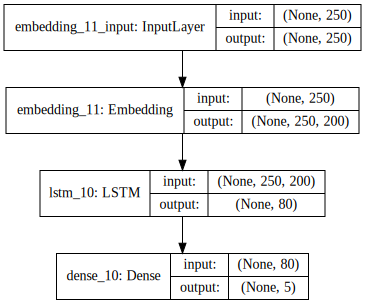

In [109]:
embedding_len = 200 # Length of the embedding vector
neuron_LSTM = 80 # Number of neurones in the hidden layer
neuron_DENSE = 5 # Number of neurones in output layer = Number of classes
p = 0.2 # Dropout probability

# Building LSTM RNN
model = Sequential()

# Embedding layer
model.add(Embedding(top_words, embedding_len, input_length=maxlen))
# model.add(Dropout(p))
model.add(LSTM(neuron_LSTM, dropout=p, recurrent_dropout=0.2))
model.add(Dense(neuron_DENSE, activation='softmax')) # Multiple classes
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
SVG(model_to_dot(model,show_shapes=True,dpi=72).create(prog='dot', format='svg'))

In [0]:
def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

def visualiza_procesamiento_LSTM(seq, y, text, interpretacion_sentimientos, model2, alpha=0.2):
    plt.figure(figsize=(15,15))
    plt.plot(sals_finales_pca_tr[inds_0,0],
             sals_finales_pca_tr[inds_0,1], '.r', alpha=alpha/2)
    plt.plot(sals_finales_pca_tr[inds_0[-1],0],
             sals_finales_pca_tr[inds_0[-1],1], '.r',
             label="Sentimiento "+interpretacion_sentimientos[0])
    plt.plot(sals_finales_pca_tr[inds_1,0],
             sals_finales_pca_tr[inds_1,1], '.', alpha=alpha)
    plt.plot(sals_finales_pca_tr[inds_1[-1],0],
             sals_finales_pca_tr[inds_1[-1],1], '.b',
             label="Sentimiento "+interpretacion_sentimientos[1])
    text_aux = [int2word[x] for x in seq]
    aux = pca.transform(model2.predict(np.array([seq]))[0])
    plt.plot(aux[:,0], aux[:,1])
    for x,w in zip(aux,text_aux):
        plt.text(x[0],x[1],w)
    plt.plot(aux[0,0],aux[0,1],'og',markersize=40,alpha=0.5)
    plt.plot(aux[0,0],aux[0,1],'og',label="Start")
    plt.plot(aux[-1,0],aux[-1,1],'oy',markersize=40,alpha=0.5)
    plt.plot(aux[-1,0],aux[-1,1],'oy',label="End")
    plt.title("{} \n Sentimiento={} ({})".format(text, y,interpretacion_sentimientos[y]),
              fontsize=16)
    plt.legend(fontsize=14);

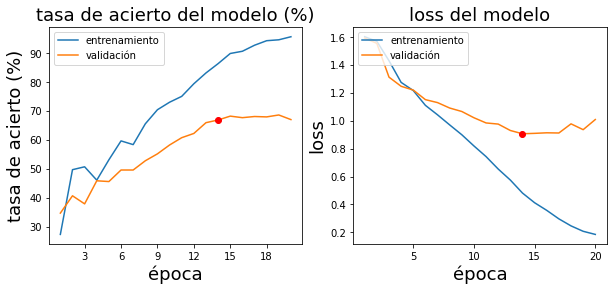

In [110]:
batch_size = 512
nepocas = 20

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

for e in range(nepocas):
  h = model.fit(X_train_pad, y_tr_num,
                batch_size=batch_size,
                validation_data=(X_val_pad, y_val_num),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [0]:
model.set_weights(best_weights)

In [112]:
model.set_weights(best_weights)
scores = model.evaluate(X_test_pad, y_te_num, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

750/750 [==============================] - 1s 2ms/step
Accuracy in test: 67.20%


## Single LSTM with Spatial Dropout

<font color="orange"><h1 align="left">Single LSTM with Spatial Dropout</h1></font>

In [0]:
top_words =  6000

tokenizer = Tokenizer(num_words = top_words,   oov_token = "oov")
tokenizer.fit_on_texts(clean_full_tr)
X_train = np.array(tokenizer.texts_to_sequences(clean_full_tr))
X_test = np.array(tokenizer.texts_to_sequences(clean_full_te))
X_val = np.array(tokenizer.texts_to_sequences(clean_full_val))

In [0]:
maxlen = 250
X_train_pad = pad_sequences(X_train, maxlen=maxlen)
X_test_pad = pad_sequences(X_test, maxlen=maxlen)
X_val_pad = pad_sequences(X_val, maxlen=maxlen)

# Add the padding element
int2word[0] = "padding"

In [0]:
embedding_len = 200 # Length of the embedding vector
neuron_LSTM = 80 # Number of neurones in the hidden layer
neuron_DENSE = 5 # Number of neurones in output layer = Number of classes
p = 0.2 # Dropout probability

# Building LSTM RNN
network = Sequential()

# Embedding layer
network.add(Embedding(top_words, embedding_len, input_length=maxlen))
network.add(SpatialDropout1D(p))
network.add(LSTM(neuron_LSTM, dropout=p, recurrent_dropout=p))
network.add(Dense(neuron_DENSE, activation='softmax')) # Multiple classes
network.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 250, 200)          1200000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 200)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 80)                89920     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 405       
Total params: 1,290,325
Trainable params: 1,290,325
Non-trainable params: 0
_________________________________________________________________


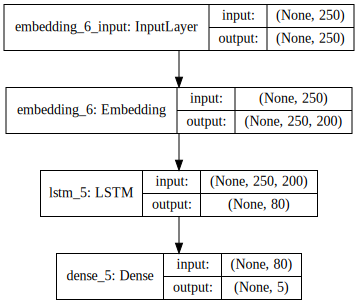

In [95]:
network.summary()
SVG(model_to_dot(model,show_shapes=True,dpi=72).create(prog='dot', format='svg'))

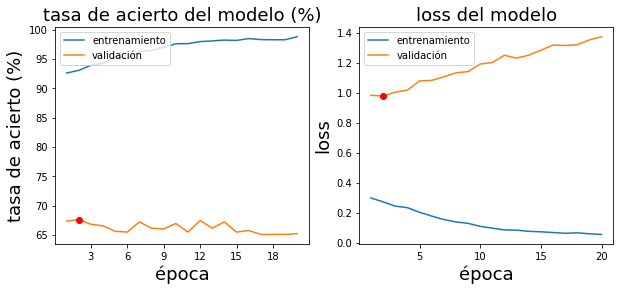

In [96]:
batch_size = 512
nepocas = 20

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

for e in range(nepocas):
  h = model.fit(X_train_pad, y_tr_num,
                batch_size=batch_size,
                validation_data=(X_val_pad, y_val_num),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [98]:
model.set_weights(best_weights)
scores = model.evaluate(X_test_pad, y_te_num, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

750/750 [==============================] - 1s 2ms/step
Accuracy in test: 71.47%


Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model. Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset.

The EarlyStopping callback will stop training once triggered, but the model at the end of training may not be the model with best performance on the validation dataset.

By default, any change in the performance measure, no matter how fractional, will be considered an improvement. You may want to consider an improvement that is a specific increment, such as 1 unit for mean squared error or 1% for accuracy. This can be specified via the “min_delta” argument.


An additional callback is required that will save the best model observed during training for later use. This is the ModelCheckpoint callback.

The ModelCheckpoint callback is flexible in the way it can be used, but in this case we will use it only to save the best model observed during training as defined by a chosen performance measure on the validation dataset.

In Keras, we can implement early stopping as a callback function. Callbacks are functions that can be applied at certain stages of the training process, such as at the end of each epoch. Specifically, in our solution, we included EarlyStopping(monitor='val_loss', patience=2) to define that we wanted to monitor the test (validation) loss at each epoch and after the test loss has not improved after two epochs, training is interrupted. However, since we set patience=2, we won’t get the best model, but the model two epochs after the best model. Therefore, optionally, we can include a second operation, ModelCheckpoint which saves the model to a file after every checkpoint (which can be useful in case a multi-day training session is interrupted for some reason. Helpful for us, if we set save_best_only=True then ModelCheckpoint will only save the best model.

We have chosen monitorized "loss function" and not "accuracy".
The loss quantify how certain the model is about a prediction (basically having a value close to 1 in the right class and close to 0 in the other classes). The accuracy merely account for the number of correct predictions. 



In [0]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=5,  min_delta=1),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [0]:
# Train neural network
history = network.fit(X_train_pad, # Features
                      y_tr_num, # Target vector
                      epochs=20, # Number of epochs
                      callbacks=callbacks, # Early stopping
                      verbose=1, # Print description after each epoch
                      batch_size=100, # Number of observations per batch
                      validation_data=(X_val_pad, y_val_num)) # Data for evaluation

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 3500 samples, validate on 750 samples
Epoch 1/20
3500/3500 [==============================] - 9s 3ms/step - loss: 1.6001 - accuracy: 0.2886 - val_loss: 1.5735 - val_accuracy: 0.3960
Epoch 2/20
3500/3500 [==============================] - 9s 3ms/step - loss: 1.4440 - accuracy: 0.4260 - val_loss: 1.2804 - val_accuracy: 0.4347
Epoch 3/20
3500/3500 [==============================] - 9s 2ms/step - loss: 1.2875 - accuracy: 0.4351 - val_loss: 1.2639 - val_accuracy: 0.4520
Epoch 4/20
3500/3500 [==============================] - 9s 3ms/step - loss: 1.2385 - accuracy: 0.4860 - val_loss: 1.1575 - val_accuracy: 0.4760
Epoch 5/20
3500/3500 [==============================] - 9s 2ms/step - loss: 1.1008 - accuracy: 0.5631 - val_loss: 1.0705 - val_accuracy: 0.5387
Epoch 6/20
3500/3500 [==============================] - 9s 2ms/step - loss: 1.0069 - accuracy: 0.6094 - val_loss: 1.0197 - val_accuracy: 0.5960
Epoch 7/20
3500/3500 [==============================] - 9s 2ms/step - loss: 0.9144 - accu

In [0]:
# load the best saved model
from keras.models import load_model
saved_model = load_model('best_model.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



In [0]:
scores = saved_model.evaluate(X_test_pad, y_te_num, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

# Grid Search Neuronal Network Optimizer

<font color="orange"><h1 align="left">Grid Search Neuronal Network Optimizer</h1></font>


In [0]:
top_words =  6000

tokenizer = Tokenizer(num_words = top_words,   oov_token = "oov")
tokenizer.fit_on_texts(clean_full_tr)
X_train = np.array(tokenizer.texts_to_sequences(clean_full_tr))
X_test = np.array(tokenizer.texts_to_sequences(clean_full_te))
X_val = np.array(tokenizer.texts_to_sequences(clean_full_val))


maxlen = 250
X_train_pad = pad_sequences(X_train, maxlen=maxlen)
X_test_pad = pad_sequences(X_test, maxlen=maxlen)
X_val_pad = pad_sequences(X_val, maxlen=maxlen)

# Add the padding element
int2word[0] = "padding"

In [0]:
def create_model(optimizer='adam'):
	# create model
	model = Sequential()
	model.add(Dense(12, input_dim=8, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model

In [0]:
def create_model(optimizer='adam'):
  embedding_len = 64 # Length of the embedding vector
  neuron_LSTM = 40 # Number of neurones in the hidden layer
  neuron_DENSE = 5 # Number of neurones in output layer = Number of classes
  p = 0.2 # Dropout probability

  # Building LSTM RNN
  model = Sequential()

  # Embedding layer
  model.add(Embedding(top_words, embedding_len, input_length=maxlen))
  model.add(SpatialDropout1D(p))
  model.add(LSTM(neuron_LSTM, dropout=p, recurrent_dropout=p))
  model.add(Dense(neuron_DENSE, activation='softmax')) # Multiple classes
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

In [0]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# create model
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=100, verbose=1)

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# optimizer = ['SGD']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2)
grid_result = grid.fit(X_train_pad, y_tr)




/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
3500/3500 [==============================] - 17s 5ms/step - loss: 1.4306 - accuracy: 0.3623
Epoch 2/20
3500/3500 [==============================] - 16s 5ms/step - loss: 1.1614 - accuracy: 0.4971
Epoch 3/20
3500/3500 [==============================] - 16s 5ms/step - loss: 1.0575 - accuracy: 0.5909
Epoch 4/20
3500/3500 [==============================] - 16s 5ms/step - loss: 0.9643 - accuracy: 0.6431
Epoch 5/20
3500/3500 [==============================] - 16s 5ms/step - loss: 0.9003 - accuracy: 0.6914
Epoch 6/20
3500/3500 [==============================] - 16s 5ms/step - loss: 0.8344 - accuracy: 0.7189
Epoch 7/20
3500/3500 [==============================] - 16s 5ms/step - loss: 0.7778 - accuracy: 0.7486
Epoch 8/20
3500/3500 [==============================] - 16s 5ms/step - loss: 0.7117 - accuracy: 0.7751
Epoch 9/20
3500/3500 [==============================] - 16s 5ms/step - loss: 0.6638 - accuracy: 0.7891
Epoch 10/20
3500/3500 [==============================] - 16s 5ms/step - l

In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.630000 using {'optimizer': 'Adagrad'}
0.211143 (0.018000) with: {'optimizer': 'SGD'}
0.629143 (0.006857) with: {'optimizer': 'RMSprop'}
0.630000 (0.010000) with: {'optimizer': 'Adagrad'}
0.508000 (0.015429) with: {'optimizer': 'Adadelta'}
0.624571 (0.010286) with: {'optimizer': 'Adam'}
0.520571 (0.050857) with: {'optimizer': 'Adamax'}
0.605714 (0.012000) with: {'optimizer': 'Nadam'}
